Download aydao-anime-danbooru2019s-512-5268480.pkl  
from https://www.gwern.net/Faces#tadne-download  
to Google Drive MyDrive/workspace.

Download and convert akai_haato.png, mori_calliope.png  
from https://www.hololive.tv/portfolio/items/akai-haato, https://www.hololive.tv/portfolio/items/mori-calliope  
to Google Drive MyDrive/workspace.

<a href="https://colab.research.google.com/github/piyo7/gan-playground/blob/main/tadne/project_morph_tadne.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Select GPU from the Hardware Accelerator.

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!git clone https://github.com/aydao/stylegan2-surgery.git
!apt install imagemagick

In [4]:
%cd /content/stylegan2-surgery

/content/stylegan2-surgery


In [5]:
!mkdir /content/images/
!convert -resize 512x512 /content/drive/MyDrive/workspace/akai_haato.png /content/images/akai_haato.png
!convert -resize 512x512 /content/drive/MyDrive/workspace/mori_calliope.png /content/images/mori_calliope.png

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from IPython.display import Image, display_png
from math import ceil
from more_itertools import windowed
from os import makedirs
from tqdm import tqdm

import dnnlib.tflib
from dnnlib import make_run_dir_path
from pretrained_networks import load_networks
from projector import Projector
from run_projector import project_image
from training.dataset import load_dataset
from training.misc import adjust_dynamic_range, save_image_grid

In [7]:
network_pkl = '/content/drive/MyDrive/workspace/aydao-anime-danbooru2019s-512-5268480.pkl'
_G, _D, Gs = load_networks(network_pkl)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [8]:
%run dataset_tool.py create_aydao ../tfrecords/ ../images/akai_haato.png akai_haato 512 512
%run dataset_tool.py create_aydao ../tfrecords/ ../images/mori_calliope.png mori_calliope 512 512

Loading images from "../images/akai_haato.png"
detected 1 images ...
Shuffle the images... using seed 123
Creating dataset "../tfrecords/"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Loading images from "../images/mori_calliope.png"
detected 1 images ...
Shuffle the images... using seed 123
Creating dataset "../tfrecords/"
Adding the images to tfrecords ...
added images 0
Added 1 images.


In [9]:
def project_real_images(Gs, dataset_name, data_dir, out_dir, num_images, num_steps, num_snapshots):
  proj = Projector()
  proj.set_network(Gs)
  proj.num_steps = num_steps # diff
  dataset_obj = load_dataset(data_dir=data_dir, tfrecord_dir=dataset_name, max_label_size=0, repeat=False, shuffle_mb=0)
  assert dataset_obj.shape == Gs.output_shape[1:]
  for image_idx in tqdm(range(num_images)):
    images, _labels = dataset_obj.get_minibatch_np(1)
    images = adjust_dynamic_range(images, [0, 255], [-1, 1])
    makedirs(out_dir, exist_ok=True) #
    png_prefix = make_run_dir_path(f'{out_dir}/image{image_idx:02}-') #
    project_image(proj, targets=images, png_prefix=png_prefix, num_snapshots=num_snapshots)
    np.save(f'{png_prefix}dlatents', proj.get_dlatents()) #

def morph_dlatents(Gs, dlatents_paths, out_dir, num_inters):
  proj = Projector()
  proj.set_network(Gs)
  nps = [np.load(path) for path in dlatents_paths]
  ds = sum([[d1 * (num_inters - i) / num_inters + d2 * i / num_inters for i in range(num_inters)] for d1, d2 in windowed(nps, 2)], []) + [nps[-1]]
  makedirs(out_dir, exist_ok=True)
  for i, d in tqdm(enumerate(ds)):
    save_image_grid(tflib.run(proj._images_expr, {proj._dlatents_expr: d}), f'{out_dir}/{i:04}.png', drange=[-1,1])

In [10]:
def displayGrid(files, size=3, columns=6):
  rows = ceil(len(files) / columns)
  fig = plt.figure(figsize=(size * columns, size * rows))
  for i, file in enumerate(files):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.imshow(plt.imread(file))
    ax.axis('off')
  plt.show()

In [11]:
project_real_images(Gs, 'akai_haato', '../tfrecords/', '../results/akai_haato/', 1, 1000, 100)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [22:14<00:00, 1334.69s/it]


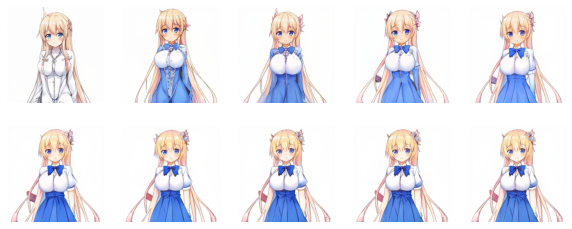

In [20]:
displayGrid([f'../results/akai_haato/image00-step{i:04}.png' for i in range(100, 1001, 100)], 2, 5)

In [14]:
project_real_images(Gs, 'mori_calliope', '../tfrecords/', '../results/mori_calliope/', 1, 1000, 100)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [22:08<00:00, 1328.63s/it]


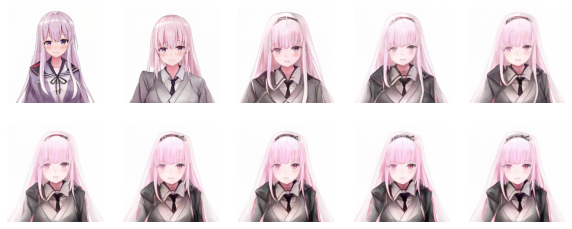

In [21]:
displayGrid([f'../results/mori_calliope/image00-step{i:04}.png' for i in range(100, 1001, 100)], 2, 5)

In [17]:
morph_dlatents(Gs, ['../results/mori_calliope/image00-dlatents.npy', '../results/akai_haato/image00-dlatents.npy'], '../results/morph/', 100)

101it [00:50,  2.00it/s]


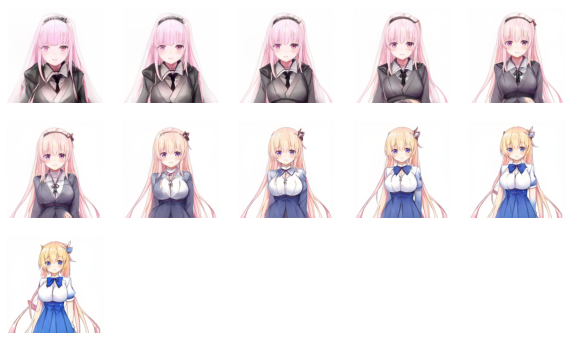

In [22]:
displayGrid([f'../results/morph/{i:04}.png' for i in range(0, 101, 10)], 2, 5)